In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

import os, PIL, pathlib,random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
data_dir = '/Users/montylee/NJUPT/Learn/Github/deeplearning/pytorch/P4/datasets/res_data'
classNames = os.listdir(data_dir)
classNames

['Others', 'Monkeypox']

In [3]:
# 在机器学习中，归一化是一种常用的数据预处理技术，
# 它的作用是使输入数据在所有特征维度上具有相似的尺度，从而提高模型训练的稳定性和收敛速度。

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean = [0.485,0.456,0.406], # RGB平均值
    std = [0.229,0.224,0.225]) # RGB标准差
])
total_data = datasets.ImageFolder(data_dir,transform=train_transforms)
total_data

Dataset ImageFolder
    Number of datapoints: 4284
    Root location: /Users/montylee/NJUPT/Learn/Github/deeplearning/pytorch/P4/datasets/res_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
total_data.class_to_idx

{'Monkeypox': 0, 'Others': 1}

In [5]:
train_size = int(0.8 * len(total_data))
test_size = len(total_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_size, test_size])
train_dataset, test_dataset, train_size, test_size

(<torch.utils.data.dataset.Subset at 0x10437be80>,
 3427,
 857)

In [6]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=1)

In [7]:
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [8]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(0.5)  # Adding dropout with a probability of 0.5

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applying dropout after the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Applying dropout after the second fully connected layer
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

model = Network()


In [9]:
# 2. 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
leaining_rate = 0.001
opt = torch.optim.Adam(model.parameters(),lr=leaining_rate)

In [10]:
# 3. 训练函数
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss, train_acc = 0, 0
    for x, y in dataloader:
        x, y  = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x) # 网络输出
        loss = loss_fn(pred, y) # 计算损失

        optimizer.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        optimizer.step() # 更新参数

        train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()

    train_acc /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [11]:
# 4. 测试函数
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y  = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)
            
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_acc /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [12]:
# 正式训练
epoches = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epoches):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)

    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)

    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%, Test_loss:{:.3f}') 
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss)) 
    
print('Done')

Epoch: 1, Train_acc:60.4%, Train_loss:0.680, Test_acc:67.9%, Test_loss:0.629
Epoch: 2, Train_acc:68.1%, Train_loss:0.606, Test_acc:69.2%, Test_loss:0.612
Epoch: 3, Train_acc:74.9%, Train_loss:0.528, Test_acc:75.1%, Test_loss:0.505
Epoch: 4, Train_acc:79.2%, Train_loss:0.443, Test_acc:83.0%, Test_loss:0.421
Epoch: 5, Train_acc:85.8%, Train_loss:0.348, Test_acc:83.9%, Test_loss:0.413
Epoch: 6, Train_acc:89.4%, Train_loss:0.285, Test_acc:87.5%, Test_loss:0.381
Epoch: 7, Train_acc:93.2%, Train_loss:0.193, Test_acc:89.6%, Test_loss:0.330
Epoch: 8, Train_acc:94.1%, Train_loss:0.166, Test_acc:90.0%, Test_loss:0.329
Epoch: 9, Train_acc:95.2%, Train_loss:0.135, Test_acc:87.0%, Test_loss:0.398
Epoch:10, Train_acc:95.4%, Train_loss:0.128, Test_acc:90.1%, Test_loss:0.401
Epoch:11, Train_acc:96.6%, Train_loss:0.104, Test_acc:89.3%, Test_loss:0.396
Epoch:12, Train_acc:97.6%, Train_loss:0.083, Test_acc:91.7%, Test_loss:0.379
Epoch:13, Train_acc:97.7%, Train_loss:0.064, Test_acc:90.4%, Test_loss:0.389

range(0, 20)


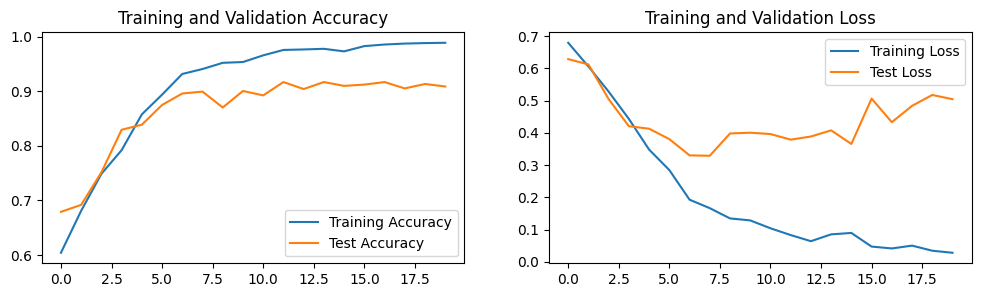

In [13]:
import matplotlib.pyplot as plt

epochs_range = range(epoches)
print(epochs_range)

plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label = 'Training Accuracy')
plt.plot(epochs_range, test_acc, label = 'Test Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label = 'Training Loss')
plt.plot(epochs_range, test_loss, label = 'Test Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()